In [53]:
%matplotlib inline
import numpy as np
np.set_printoptions(edgeitems=10)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pydotplus
from IPython.display import Image  
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, LabelBinarizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.decomposition import PCA

In [54]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
gm_df = pd.read_csv('data/gendermodel.csv')
test_df.insert(1, 'Survived', gm_df['Survived'])
train_df = train_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
train_df.head()

Survived  Pclass     Sex   Age  SibSp  Parch     Fare Embarked
0         0       3    male  22.0      1      0   7.2500        S
1         1       1  female  38.0      1      0  71.2833        C
2         1       3  female  26.0      0      0   7.9250        S
3         1       1  female  35.0      1      0  53.1000        S
4         0       3    male  35.0      0      0   8.0500        S

In [55]:
test_df = test_df.dropna()
train_df = train_df.dropna()
def create_family(df):
    family = df['SibSp'].values + df['Parch'].values
    df = df.drop(['SibSp', 'Parch'], axis=1)
    df.insert(4, 'Family', family)
    return df
train_df = create_family(train_df)
test_df = create_family(test_df)
train_df.head()

Survived  Pclass     Sex   Age  Family     Fare Embarked
0         0       3    male  22.0       1   7.2500        S
1         1       1  female  38.0       1  71.2833        C
2         1       3  female  26.0       0   7.9250        S
3         1       1  female  35.0       1  53.1000        S
4         0       3    male  35.0       0   8.0500        S

In [56]:
train_X = train_df.iloc[:, 1:].values
train_y = train_df.iloc[:, 0].values
test_X = test_df.iloc[:, 1:].values
test_y = test_df.iloc[:,0].values

In [57]:
# switch pclass labels since 1st class is greater than 3rd class
map_dict = {1: 3, 2: 2, 3: 1}
def val_map(val):
    return map_dict[val]
arr_map = np.vectorize(val_map)
train_X[:, 0] = arr_map(train_X[:, 0])
test_X[:, 0] = arr_map(test_X[:, 0])

sex_le = LabelEncoder()
train_X[:, 1] = sex_le.fit_transform(train_X[:, 1])
test_X[:, 1] = sex_le.transform(test_X[:, 1])

embarked_le = LabelEncoder()
train_X[:, 5] = embarked_le.fit_transform(train_X[:, 5])
test_X[:, 5] = embarked_le.transform(test_X[:, 5])
print(embarked_le.classes_)

train_X

['C' 'Q' 'S']


array([[1, 1, 22.0, 1, 7.25, 2],
       [3, 0, 38.0, 1, 71.2833, 0],
       [1, 0, 26.0, 0, 7.925, 2],
       [3, 0, 35.0, 1, 53.1, 2],
       [1, 1, 35.0, 0, 8.05, 2],
       [3, 1, 54.0, 0, 51.8625, 2],
       [1, 1, 2.0, 4, 21.075, 2],
       [1, 0, 27.0, 2, 11.1333, 2],
       [2, 0, 14.0, 1, 30.0708, 0],
       [1, 0, 4.0, 2, 16.7, 2],
       ..., 
       [2, 0, 25.0, 1, 26.0, 2],
       [1, 1, 33.0, 0, 7.8958, 2],
       [1, 0, 22.0, 0, 10.5167, 2],
       [2, 1, 28.0, 0, 10.5, 2],
       [1, 1, 25.0, 0, 7.05, 2],
       [1, 0, 39.0, 5, 29.125, 1],
       [2, 1, 27.0, 0, 13.0, 2],
       [3, 0, 19.0, 0, 30.0, 2],
       [3, 1, 26.0, 0, 30.0, 0],
       [1, 1, 32.0, 0, 7.75, 1]], dtype=object)

In [58]:
# now to do one hot encoding on the nominal features
ohe = OneHotEncoder(categorical_features=[1, 5])
ohe.fit(train_X)
train_X = ohe.transform(train_X).toarray()
test_X = ohe.transform(test_X).toarray()

In [59]:
# for future reference:
total_features = [
    'Male',
    'Female',
    'Cherbourg',
    'Queenstown',
    'Southampton',
    'PClass',
    'Age',
    'Family',
    'Fare'
]
for index, feature in zip(range(9), total_features):
    print(index, feature)

0 Male
1 Female
2 Cherbourg
3 Queenstown
4 Southampton
5 PClass
6 Age
7 Family
8 Fare


In [60]:
scaler = StandardScaler()
train_X[:, 6:] = scaler.fit_transform(train_X[:, 6:])
test_X[:, 6:] = scaler.transform(test_X[:, 6:])

In [61]:
lda = PCA(n_components=2)
translated_data = lda.fit(train_X, train_y).transform(train_X)

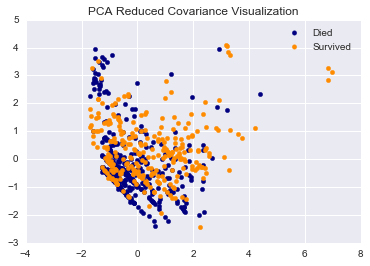

In [62]:
plt.scatter(translated_data[train_y == 0, 0], translated_data[train_y == 0, 1], color='navy',
           label='Died')
plt.scatter(translated_data[train_y == 1, 0], translated_data[train_y == 1, 1], color='darkorange', 
           label='Survived')
plt.legend()
plt.title('PCA Reduced Covariance Visualization')
plt.show()

In [63]:
log = LogisticRegression()
log.fit(train_X, train_y)
pred_y = log.predict(test_X)
print(accuracy_score(test_y, pred_y))
print(classification_report(test_y, pred_y, target_names=total_features))
log.coef_[0].dtype

0.918429003021
             precision    recall  f1-score   support

       Male       0.95      0.91      0.93       204
     Female       0.87      0.93      0.90       127

avg / total       0.92      0.92      0.92       331



dtype('float64')

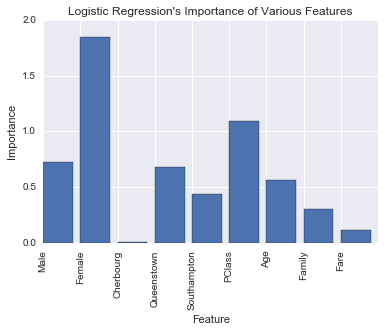

In [64]:
plt.bar(list(range(9)), abs(log.coef_[0]))
plt.xticks(list(range(9)), total_features, rotation=90, )
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Logistic Regression\'s Importance of Various Features')
plt.show()

In [65]:
dtc = DecisionTreeClassifier(random_state=0)
dtc.fit(train_X, train_y)
pred_y = dtc.predict(test_X)
print(accuracy_score(test_y, pred_y))
print(classification_report(test_y, pred_y, target_names=total_features))

0.761329305136
             precision    recall  f1-score   support

       Male       0.83      0.76      0.80       204
     Female       0.67      0.76      0.71       127

avg / total       0.77      0.76      0.76       331



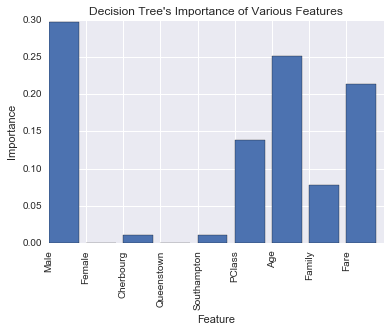

In [66]:
plt.bar(list(range(9)), dtc.feature_importances_)
plt.xticks(list(range(9)), total_features, rotation=90, )
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Decision Tree\'s Importance of Various Features')
plt.show()

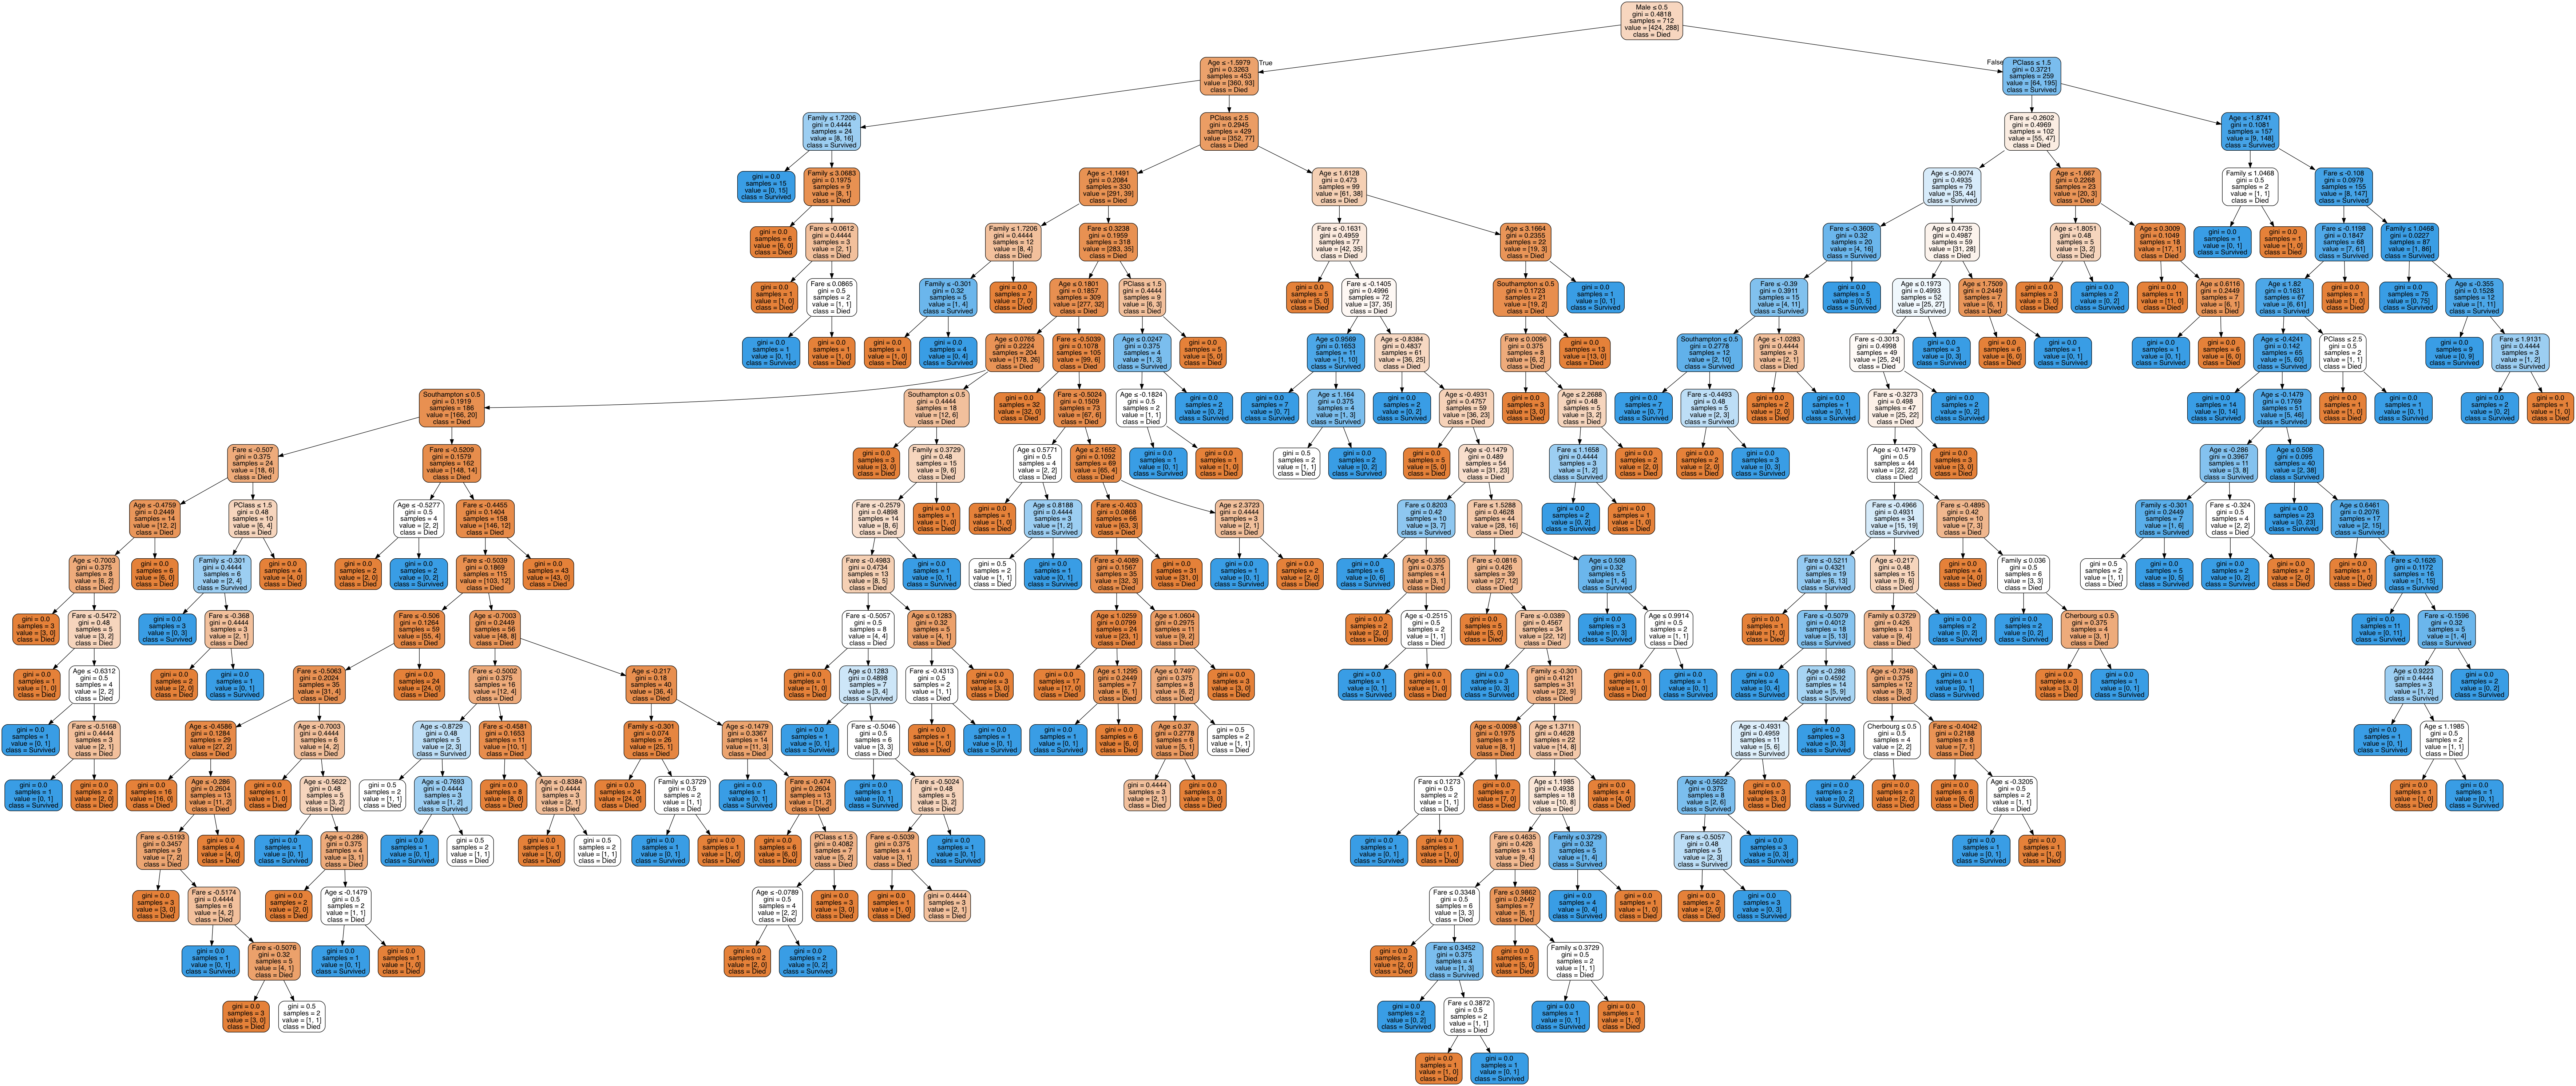

In [67]:
dot_data = export_graphviz(dtc, out_file=None, 
                         feature_names=total_features,  
                         class_names=['Died', 'Survived'],  
                         filled=True, rounded=True,  
                         special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())  